In [1]:
import os
import wget
import healpy as hp
import numpy as np
from tqdm import tqdm
from astropy.io import fits as pyfits
import random
import pymp
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from threadpoolctl import threadpool_limits
import importlib
import sys
import multiprocessing as mp
from math import sqrt
from math import radians
import gc
import subprocess
gc.disable()
#######################################################################################################
from cmbaberdopp import * # cmbboost its a module created w/ the functions needed for this work          #
                       # remember to change the path of maps on dipole_doppler_load_low_res function  #
#######################################################################################################
def c_nthreads_limit(n): # Function to change number of threads used on imported C/C++ functions
    threadpool_limits(limits=n, user_api='blas')
    threadpool_limits(limits=n, user_api='openmp')

In [ ]:
# Download Planck final SMICA and NILC maps to get realistic beam function

wget.download('http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CMB_IQU-smica_2048_R3.00_full.fits')
wget.download('http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CMB_IQU-nilc_2048_R3.00_full.fits')

# Debeamed

In [2]:
#### Importing effective beam and masks files####

lmax_var = 2048
pw = hp.pixwin(nside=2048,lmax=lmax_var)

clfile_TT='cl_TT_planck_2019.fits'
cl_TT = hp.read_cl(clfile_TT)
clfile_EE='cl_EE_planck_2019.fits'
cl_EE = hp.read_cl(clfile_EE)
clfile_TE='cl_TE_planck_2019.fits'
cl_TE = hp.read_cl(clfile_TE)


nilcgb = pyfits.open('COM_CMB_IQU-nilc_2048_R3.00_full.fits')[2].data['INT_BEAM'][0:lmax_var]
nilcgb[0]=1
nilcgb[1]=1
#hp.write_cl('nilc_T_effective_beam.fits',nilcgb)
nilcgb_P = pyfits.open('COM_CMB_IQU-nilc_2048_R3.00_full.fits')[2].data['POL_BEAM'][0:lmax_var]
nilcgb_P[0]=1
nilcgb_P[1]=1
#hp.write_cl('nilc_P_effective_beam.fits',nilcgb_P)
smicagb = pyfits.open('COM_CMB_IQU-smica_2048_R3.00_full.fits')[2].data['INT_BEAM'][0:lmax_var]
smicagb[0]=1
smicagb[1]=1
#hp.write_cl('smica_T_effective_beam.fits',smicagb)
smicagb_P = pyfits.open('COM_CMB_IQU-smica_2048_R3.00_full.fits')[2].data['POL_BEAM'][0:lmax_var]
smicagb_P[0]=1
smicagb_P[1]=1
#hp.write_cl('smica_P_effective_beam.fits',smicagb_P)

masksymm_temp = hp.read_map('temp_symmmask_pr3.fits',verbose=False)
masksymm_pol = hp.read_map('pol_symmmask_pr3.fits',verbose=False)


/home/pedro/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [3]:
nilc_T_nl = hp.read_cl('nl_nilc_T_symmmasked.fits')
smica_T_nl = hp.read_cl('nl_smica_T_symmmasked.fits')
nilc_E_nl = hp.read_cl('nl_nilc_E_symmmasked.fits')
smica_E_nl = hp.read_cl('nl_smica_E_symmmasked.fits')

In [4]:
pw = hp.pixwin(nside=2048,lmax=2048)

In [5]:
dipole_lat = 48.253
dipole_long = 264.021
dipole_beta = 0.00123357
fiducialvec = hp.ang2vec(dipole_long,dipole_lat,lonlat=True)*dipole_beta
fiducialvecnorm = np.linalg.norm(fiducialvec)

nside=2048 # Setting the nside we will use

#delta1modulationmap = doppler_boost_map_dir_s(beta_var=dipole_beta,nside_var=nside,longdir=dipole_long,latdir=dipole_lat)
delta1modulationmap = np.sum(fiducialvec*np.array(hp.pix2vec(2048,np.arange(hp.nside2npix(2048)))).T,axis=1)

In [6]:
DD_l_nilc = np.loadtxt('nilc_DD_by_ell.dat')
DD_l_smica = np.loadtxt('smica_DD_by_ell.dat')

DD_EE_l_nilc = np.loadtxt('nilc_DD_EE_by_ell.dat')
DD_EE_l_smica = np.loadtxt('smica_DD_EE_by_ell.dat')

In [7]:
c_nthreads_limit(16)

##### Importing Planck OBS maps #####
nilc_I_obs_map, nilc_Q_obs_map, nilc_U_obs_map = hp.read_map('COM_CMB_IQU-nilc_2048_R3.00_full.fits',field=(0,1,2))
nilc_T_obs_alm, nilc_E_obs_alm, nilc_B_obs_alm = hp.map2alm((nilc_I_obs_map,nilc_Q_obs_map, nilc_U_obs_map),lmax=2048)
nilc_T_obs_debeamed_alm = hp.almxfl(nilc_T_obs_alm,1/(nilcgb[0:lmax_var+1]))
nilc_E_obs_debeamed_alm = hp.almxfl(nilc_E_obs_alm,1/(nilcgb_P[0:lmax_var+1]))
nilc_B_obs_debeamed_alm = hp.almxfl(nilc_B_obs_alm,1/(nilcgb_P[0:lmax_var+1]))
nilc_I_obs_debeamed_map, nilc_Q_obs_debeamed_map, nilc_U_obs_debeamed_map = hp.alm2map((nilc_T_obs_debeamed_alm,nilc_E_obs_debeamed_alm,nilc_B_obs_debeamed_alm),nside=2048)

#hp.write_alm('planck_obs_nilc_T_obs_debeamed_alm.fits',nilc_T_obs_debeamed_alm,overwrite=True)
#hp.write_alm('planck_obs_nilc_E_obs_debeamed_alm.fits',nilc_E_obs_debeamed_alm,overwrite=True)
#hp.write_alm('planck_obs_nilc_B_obs_debeamed_alm.fits',nilc_B_obs_debeamed_alm,overwrite=True)

smica_I_obs_map, smica_Q_obs_map, smica_U_obs_map = hp.read_map('COM_CMB_IQU-smica_2048_R3.00_full.fits',field=(0,1,2))
smica_T_obs_alm, smica_E_obs_alm, smica_B_obs_alm = hp.map2alm((smica_I_obs_map,smica_Q_obs_map, smica_U_obs_map),lmax=2048)
smica_T_obs_debeamed_alm = hp.almxfl(smica_T_obs_alm,1/(smicagb[0:lmax_var+1]))
smica_E_obs_debeamed_alm = hp.almxfl(smica_E_obs_alm,1/(smicagb_P[0:lmax_var+1]))
smica_B_obs_debeamed_alm = hp.almxfl(smica_B_obs_alm,1/(smicagb_P[0:lmax_var+1]))
smica_I_obs_debeamed_map, smica_Q_obs_debeamed_map, smica_U_obs_debeamed_map = hp.alm2map((smica_T_obs_debeamed_alm,smica_E_obs_debeamed_alm,smica_B_obs_debeamed_alm),nside=2048)

#####

#hp.write_alm('planck_obs_smica_T_obs_debeamed_alm.fits',smica_T_obs_debeamed_alm,overwrite=True)
#hp.write_alm('planck_obs_smica_E_obs_debeamed_alm.fits',smica_E_obs_debeamed_alm,overwrite=True)
#hp.write_alm('planck_obs_smica_B_obs_debeamed_alm.fits',smica_B_obs_debeamed_alm,overwrite=True)

lmax_var = 2048
LDelta1=hp.map2alm(nilc_I_obs_debeamed_map*delta1modulationmap,lmax=2048)
nilc_T_new_DD_removal = nilc_T_obs_debeamed_alm-hp.almxfl(LDelta1,DD_l_nilc)

lmax_var = 2048
LDelta1=hp.map2alm(smica_I_obs_debeamed_map*delta1modulationmap,lmax=2048)
smica_T_new_DD_removal = smica_T_obs_debeamed_alm-hp.almxfl(LDelta1,DD_l_smica)

######

lmax_var = 2048
LDelta1_T,LDelta1_E,LDelta1_B=hp.map2alm([nilc_I_obs_debeamed_map*delta1modulationmap,nilc_Q_obs_debeamed_map*delta1modulationmap,nilc_U_obs_debeamed_map*delta1modulationmap],lmax=2048)
nilc_E_new_DD_removal = nilc_E_obs_debeamed_alm-hp.almxfl(LDelta1_E,DD_EE_l_nilc)
nilc_B_new_DD_removal = nilc_E_new_DD_removal*0


LDelta1_T,LDelta1_E,LDelta1_B=hp.map2alm([smica_I_obs_debeamed_map*delta1modulationmap,smica_Q_obs_debeamed_map*delta1modulationmap,smica_U_obs_debeamed_map*delta1modulationmap],lmax=2048)
smica_E_new_DD_removal = smica_E_obs_debeamed_alm-hp.almxfl(LDelta1_E,DD_EE_l_smica)
smica_B_new_DD_removal = smica_E_new_DD_removal*0


nilc_I_obs_debeamed_map, nilc_Q_obs_debeamed_map, nilc_U_obs_debeamed_map = hp.alm2map((nilc_T_new_DD_removal,nilc_E_new_DD_removal,nilc_B_new_DD_removal),nside=2048)
smica_I_obs_debeamed_map, smica_Q_obs_debeamed_map, smica_U_obs_debeamed_map = hp.alm2map((smica_T_new_DD_removal,smica_E_new_DD_removal,smica_B_new_DD_removal),nside=2048)

nilc_I_obs_symmasked_map = nilc_I_obs_debeamed_map*masksymm_temp
nilc_Q_obs_symmasked_map = nilc_Q_obs_debeamed_map*masksymm_pol
nilc_U_obs_symmasked_map = nilc_U_obs_debeamed_map*masksymm_pol
smica_I_obs_symmasked_map = smica_I_obs_debeamed_map*masksymm_temp
smica_Q_obs_symmasked_map = smica_Q_obs_debeamed_map*masksymm_pol
smica_U_obs_symmasked_map = smica_U_obs_debeamed_map*masksymm_pol

nilc_T_new_DD_removal,nilc_E_new_DD_removal,nilc_B_new_DD_removal = hp.map2alm((nilc_I_obs_symmasked_map,nilc_Q_obs_symmasked_map,nilc_U_obs_symmasked_map),lmax=2048)
smica_T_new_DD_removal,smica_E_new_DD_removal,smica_B_new_DD_removal = hp.map2alm((smica_I_obs_symmasked_map,smica_Q_obs_symmasked_map,smica_U_obs_symmasked_map),lmax=2048)

/home/pedro/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/pedro/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/pedro/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))
/home/pedro/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/home/pedro/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering converted to RING
  warnings.warn("Ordering converted to RING")
/home/pedro/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/hom

In [9]:
lmax = 2048

mastermatrixfileTT='master_matrix_TT_pr3.csv'
mastermatrixTT=np.genfromtxt(mastermatrixfileTT, delimiter=',')
mastermatrixTT[:,0:2]=0
mastermatrizsizeTT=len(mastermatrixTT)
cl_TT=cl_TT[:mastermatrizsizeTT]
cl_TT=np.dot(mastermatrixTT,cl_TT)[0:lmax+2]

mastermatrixfileEE='master_matrix_EE_pr3.csv'
mastermatrixEE=np.genfromtxt(mastermatrixfileEE, delimiter=',')
mastermatrixEE[:,0:2]=0
mastermatrizsizeEE=len(mastermatrixEE)
cl_EE=cl_EE[:mastermatrizsizeEE]
cl_EE=np.dot(mastermatrixEE,cl_EE)[0:lmax+2]

sims_nilc_cl_TT = cl_TT[:lmax+1]+nilc_T_nl[:lmax+1]
sims_smica_cl_TT = cl_TT[:lmax+1]+smica_T_nl[:lmax+1]
sims_nilc_cl_EE = cl_EE[:lmax+1]+nilc_E_nl[:lmax+1]
sims_smica_cl_EE = cl_EE[:lmax+1]+smica_E_nl[:lmax+1]

In [16]:
bin_size = 10

clTTnilcOBS,clEEnilcOBS,clBBnilcOBS,clTEnilcOBS,clEBnilcOBS,clTBnilcOBS = hp.alm2cl((nilc_T_new_DD_removal,nilc_E_new_DD_removal,nilc_B_new_DD_removal))
clTTsmicaOBS,clEEsmicaOBS,clBBsmicaOBS,clTEsmicaOBS,clEBsmicaOBS,clTBnilcOBS =hp.alm2cl((smica_T_new_DD_removal,smica_E_new_DD_removal,smica_B_new_DD_removal))


nilc_TT_beta_corr_bin_factors = np.array([(np.sum((sims_nilc_cl_TT[bin*bin_size:(bin+1)*bin_size]/clTTnilcOBS[bin*bin_size:(bin+1)*bin_size])*(2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))/np.sum((2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))) for bin in range(200)])
smica_TT_beta_corr_bin_factors = np.array([(np.sum((sims_smica_cl_TT[bin*bin_size:(bin+1)*bin_size]/clTTsmicaOBS[bin*bin_size:(bin+1)*bin_size])*(2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))/np.sum((2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))) for bin in range(200)])
nilc_EE_beta_corr_bin_factors = np.array([(np.sum((sims_nilc_cl_EE[bin*bin_size:(bin+1)*bin_size]/clEEnilcOBS[bin*bin_size:(bin+1)*bin_size])*(2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))/np.sum((2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))) for bin in range(200)])
smica_EE_beta_corr_bin_factors = np.array([(np.sum((sims_smica_cl_EE[bin*bin_size:(bin+1)*bin_size]/clEEsmicaOBS[bin*bin_size:(bin+1)*bin_size])*(2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))/np.sum((2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))) for bin in range(200)])

np.savetxt('nilc_TT_beta_new_order_corr_bin_factors.txt',nilc_TT_beta_corr_bin_factors)
np.savetxt('smica_TT_beta_new_order_corr_bin_factors.txt',smica_TT_beta_corr_bin_factors)
np.savetxt('nilc_EE_beta_new_order_corr_bin_factors.txt',nilc_EE_beta_corr_bin_factors)
np.savetxt('smica_EE_beta_new_order_corr_bin_factors.txt',smica_EE_beta_corr_bin_factors)

<ipython-input-16-51c54ed99ae7>:9: RuntimeWarning: divide by zero encountered in true_divide
  nilc_EE_beta_corr_bin_factors = np.array([(np.sum((sims_nilc_cl_EE[bin*bin_size:(bin+1)*bin_size]/clEEnilcOBS[bin*bin_size:(bin+1)*bin_size])*(2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))/np.sum((2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))) for bin in range(200)])
<ipython-input-16-51c54ed99ae7>:10: RuntimeWarning: divide by zero encountered in true_divide
  smica_EE_beta_corr_bin_factors = np.array([(np.sum((sims_smica_cl_EE[bin*bin_size:(bin+1)*bin_size]/clEEsmicaOBS[bin*bin_size:(bin+1)*bin_size])*(2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))/np.sum((2*np.arange(bin*bin_size,(bin+1)*bin_size)+1))) for bin in range(200)])


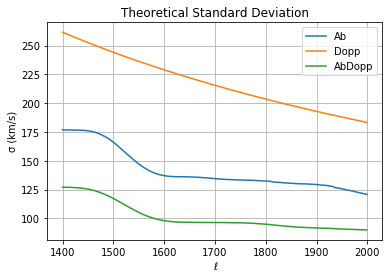

Completed in:  3.0651779174804688  seconds.


In [11]:
#### Estimating NILC TT symmmasked Beta ####

htheofast(cl_TT,nlfile='nl_nilc_T_symmmasked.fits',binsize=10,plot_std=True,threads=8)
nilc_alm_T_debeamed_symmasked2 = reorder_idxpy2pix(nilc_T_new_DD_removal,threads=8)
betafast(nilc_alm_T_debeamed_symmasked2,binsize=10,threads=12,sufixname='nilc_T_obs_symmmasked_new_order_',verbose=False,export_results=True);


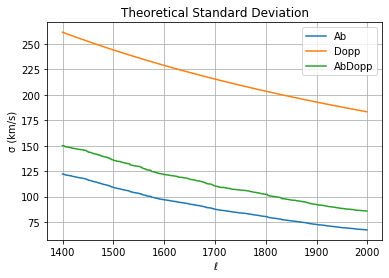

Completed in:  3.165971040725708  seconds.


In [12]:
htheofast(cl_EE,nlfile='nl_nilc_E_symmmasked.fits',binsize=10,plot_std=True,threads=8)
nilc_alm_E_debeamed_symmasked2 = reorder_idxpy2pix(nilc_E_new_DD_removal,threads=8)
betafast(nilc_alm_E_debeamed_symmasked2,binsize=10,threads=12,sufixname='nilc_E_obs_symmmasked_new_order_',verbose=False,export_results=True);


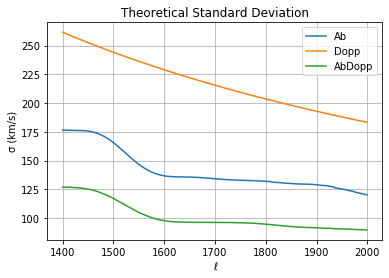

Completed in:  3.1838254928588867  seconds.


In [13]:
#### Estimating SMICA TT symmmasked Beta ####

htheofast(cl_TT,nlfile='nl_smica_T_symmmasked.fits',binsize=10,plot_std=True,threads=8)
smica_alm_T_debeamed_symmasked2 = reorder_idxpy2pix(smica_T_new_DD_removal,threads=8)
betafast(smica_alm_T_debeamed_symmasked2,binsize=10,threads=12,sufixname='smica_T_obs_symmmasked_new_order_',verbose=False,export_results=True);


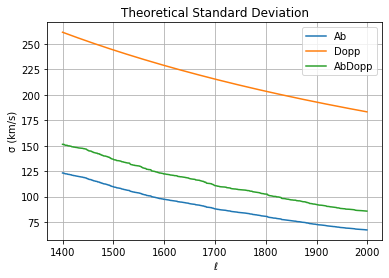

Completed in:  3.1472394466400146  seconds.


In [14]:
htheofast(cl_EE,nlfile='nl_smica_E_symmmasked.fits',binsize=10,plot_std=True,threads=8)
smica_alm_E_debeamed_symmasked2 = reorder_idxpy2pix(smica_E_new_DD_removal,threads=8)
betafast(smica_alm_E_debeamed_symmasked2,binsize=10,threads=12,sufixname='smica_E_obs_symmmasked_new_order_',verbose=False,export_results=True);
